In [1]:
import pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv("UFC Data/preprocessed_data.csv")
df_raw = pd.read_csv("UFC Data/data.csv")

In [2]:
df.head()

Winner  title_bout  no_of_rounds  B_current_lose_streak  \
0    Red        True             5                    0.0   
1    Red        True             5                    0.0   
2    Red       False             3                    0.0   
3   Blue       False             3                    0.0   
4   Blue       False             3                    0.0   

   B_current_win_streak  B_draw  B_avg_BODY_att  B_avg_BODY_landed  \
0                   4.0     0.0        9.200000           6.000000   
1                   3.0     0.0       14.600000           9.100000   
2                   3.0     0.0       15.354839          11.322581   
3                   4.0     0.0       17.000000          14.000000   
4                   1.0     0.0       17.000000          14.500000   

   B_avg_CLINCH_att  B_avg_CLINCH_landed  ...  \
0          0.200000             0.000000  ...   
1         11.800000             7.300000  ...   
2          6.741935             4.387097  ...   
3         13.750000            11.000000  ...   
4          2.500000             2.000000  ...   

   weight_class_Women's Strawweight  B_Stance_Open Stance  B_Stance_Orthodox  \
0                                 0                     0                  1   
1                                 0                     0                  1   
2                                 0                     0                  1   
3                                 0                     0                  0   
4                                 0                     0                  0   

   B_Stance_Sideways  B_Stance_Southpaw  B_Stance_Switch  \
0                  0                  0                0   
1                  0                  0                0   
2                  0                  0                0   
3                  0                  0                1   
4                  0                  1                0   

   R_Stance_Open Stance  R_Stance_Orthodox  R_Stance_Southpaw  R_Stance_Switch  
0                     0                  1                  0                0  
1                     0                  0                  1                0  
2                     0                  1                  0                0  
3                     0                  1                  0                0  
4                     0                  0                  1                0  

[5 rows x 160 columns]

In [3]:
refs = df_raw.groupby(['Referee'], as_index=False)['B_avg_BODY_att', 'B_avg_GROUND_att', 'B_avg_HEAD_att', 
                                                   'R_avg_BODY_att', 'R_avg_GROUND_att', 'R_avg_HEAD_att'].mean()
refs.head()

<ipython-input-3-cb0faf9d57e1>:1: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  refs = df_raw.groupby(['Referee'], as_index=False)['B_avg_BODY_att', 'B_avg_GROUND_att', 'B_avg_HEAD_att',


Referee  B_avg_BODY_att  B_avg_GROUND_att  B_avg_HEAD_att  \
0   Adam Cheadle       13.277778         12.388889       66.333333   
1  Adam Martinez        7.213462         13.589423       44.180128   
2       Al Coley        0.000000          0.000000       30.000000   
3      Al Guinee       16.823333          6.455000       68.771667   
4    Al Wichgers        1.000000          7.000000       11.000000   

   R_avg_BODY_att  R_avg_GROUND_att  R_avg_HEAD_att  
0       15.166667          7.775000       66.283333  
1        6.918864          8.841026       56.809158  
2        8.821429          8.392857       36.500000  
3       11.810000         10.917778       77.121111  
4       11.666667         12.083333       55.666667

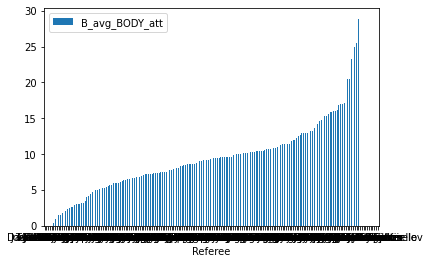

In [4]:
refs.sort_values(by=['B_avg_BODY_att']).plot.bar(x='Referee', y='B_avg_BODY_att', rot=0)

# Shows each referee's average B_avg_BODY_att, some weird outliers

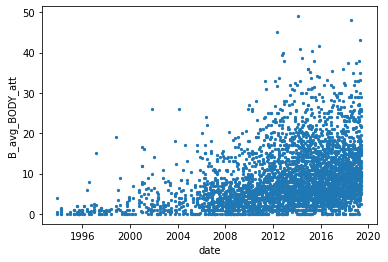

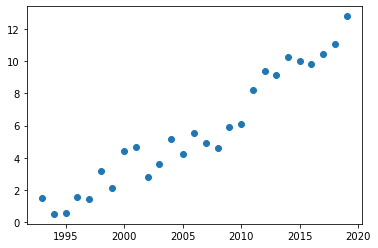

In [29]:
df_raw['date'] = pd.to_datetime(df_raw['date'])


df_raw.plot.scatter(x='date', y='B_avg_BODY_att', marker = '.')
plt.show()

yrs = df_raw.groupby(df_raw['date'].dt.year)['B_avg_BODY_att'].mean()
plt.scatter(yrs.index, yrs)

# The average B_avg_BODY_att increases linearly over the years

In [6]:
# Stance stuff

stance = df_raw[['Winner', 'B_Stance', 'R_Stance']].copy()
stance['Win_Stance'] = [b_stance if winner == 'Blue' else r_stance 
                        for winner, b_stance, r_stance in 
                        zip(stance['Winner'], stance['B_Stance'], stance['R_Stance'])]
stance['Lose_Stance'] = [b_stance if winner == 'Red' else r_stance 
                         for winner, b_stance, r_stance in 
                         zip(stance['Winner'], stance['B_Stance'], stance['R_Stance'])]

stance = stance[stance['Win_Stance'] != stance['Lose_Stance']].dropna()[['Win_Stance', 'Lose_Stance']]

In [7]:
for win_stance in stance['Win_Stance'].unique():
    for lose_stance in stance['Lose_Stance'].unique():
        if win_stance != lose_stance:
            w = len(stance[(stance['Win_Stance'] == win_stance) & (stance['Lose_Stance'] == lose_stance)].index)
            l = len(stance[(stance['Win_Stance'] == lose_stance) & (stance['Lose_Stance'] == win_stance)].index)
            if w < 40:
                break
            print(win_stance + " beat " + lose_stance + " in " + str(round(w/(w+l),2)) + "% of matches")

Southpaw beat Orthodox in 0.54% of matches
Switch beat Orthodox in 0.51% of matches
Orthodox beat Switch in 0.49% of matches
Orthodox beat Southpaw in 0.46% of matches


In [8]:
# Random Forest to predict winner

df_pred = df[['Winner', 
              'B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_PASS', 'B_avg_TD_landed', 'B_win_by_KO/TKO', 'B_wins',
              'R_avg_BODY_att', 'R_avg_BODY_landed', 'R_avg_PASS', 'R_avg_TD_landed', 'R_win_by_KO/TKO', 'R_wins']].copy()

df_pred = df_pred.rename(columns={'Winner': 'Blue_Wins'})
df_pred['Blue_Wins'] = [1 if winner == 'Blue' else 0
                        for winner, in zip(df_pred['Blue_Wins'])]
df_pred

Blue_Wins  B_avg_BODY_att  B_avg_BODY_landed  B_avg_PASS  \
0             0        9.200000           6.000000    0.400000   
1             0       14.600000           9.100000    0.800000   
2             0       15.354839          11.322581    0.935484   
3             1       17.000000          14.000000    0.500000   
4             1       17.000000          14.500000    0.000000   
...         ...             ...                ...         ...   
3587          0        1.000000           1.000000    0.000000   
3588          0        0.000000           0.000000    1.000000   
3589          0        0.500000           0.500000    0.000000   
3590          0        0.000000           0.000000    0.000000   
3591          0        4.000000           3.000000    0.000000   

      B_avg_TD_landed  B_win_by_KO/TKO  B_wins  R_avg_BODY_att  \
0            0.200000              2.0     4.0       21.900000   
1            0.500000              0.0     4.0       12.000000   
2            0.677419             10.0    23.0       13.866667   
3            1.250000              2.0     4.0       18.250000   
4            0.000000              0.0     1.0        7.750000   
...               ...              ...     ...             ...   
3587         0.000000              1.0     1.0        0.000000   
3588         1.000000              0.0     1.0        1.000000   
3589         0.000000              2.0     2.0        0.000000   
3590         1.000000              0.0     1.0        0.000000   
3591         0.000000              1.0     1.0        0.000000   

      R_avg_BODY_landed  R_avg_PASS  R_avg_TD_landed  R_win_by_KO/TKO  R_wins  
0             16.400000    1.200000         1.900000              2.0     8.0  
1              7.714286    1.714286         2.428571              0.0     5.0  
2              8.666667    0.333333         0.400000              3.0    14.0  
3             10.250000    0.125000         0.625000              1.0     6.0  
4              6.750000    0.250000         0.000000              2.0     3.0  
...                 ...         ...              ...              ...     ...  
3587           0.000000    2.000000         1.000000              0.0     1.0  
3588           1.000000    0.000000         0.000000              0.0     1.0  
3589           0.000000    2.000000         0.500000              0.0     2.0  
3590           0.000000    2.000000         1.000000              0.0     1.0  
3591           0.000000    0.000000         0.000000              1.0     1.0  

[3592 rows x 13 columns]

In [9]:
import statsmodels.api as sm

# Initial regression
YVar = df_pred[["Blue_Wins"]]
XVar = df_pred[['B_avg_BODY_att', 'B_avg_BODY_landed', 'B_avg_TD_landed',
                'R_avg_BODY_att', 'R_avg_BODY_landed', 'R_wins']]
              
LinearModel = sm.OLS(YVar, XVar, missing='drop').fit()
print(LinearModel.summary(),end="\n\n")

                                 OLS Regression Results                                
Dep. Variable:              Blue_Wins   R-squared (uncentered):                   0.344
Model:                            OLS   Adj. R-squared (uncentered):              0.343
Method:                 Least Squares   F-statistic:                              313.5
Date:                Fri, 18 Dec 2020   Prob (F-statistic):                   9.88e-324
Time:                        16:24:59   Log-Likelihood:                         -2388.2
No. Observations:                3592   AIC:                                      4788.
Df Residuals:                    3586   BIC:                                      4826.
Df Model:                           6                                                  
Covariance Type:            nonrobust                                                  
                        coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------

In [10]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import numpy as np

X_train, X_test, y_train, y_test = train_test_split(XVar, YVar, test_size=0.33, random_state=42)

clf = RandomForestClassifier(n_estimators=100)
clf = clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

print(((np.array(y_pred)-np.array(y_test.values.ravel()))**2).sum()) # Number of incorrect classifications
print(y_pred.shape[0]) # Number of total classifications

# It got 425 wrong out of 1186, so it got about 65% right!

<ipython-input-10-ccc7e4b0c0c5>:8: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf = clf.fit(X_train, y_train)


435
1186


In [11]:
# But looks like red wins about 66% of the time anyway, so not much new information here

print(df_pred[["Blue_Wins"]].sum()[0])

print(df_pred[["Blue_Wins"]].shape[0])

1212
3592


In [12]:
# Some EDA stuff

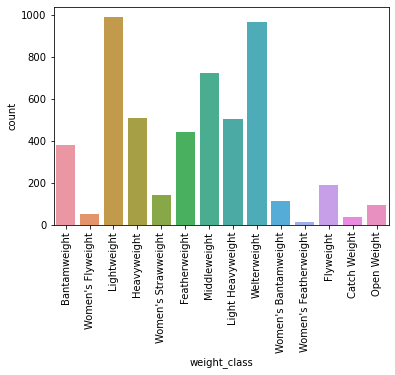

In [14]:
# Different weight classes

plt.xticks(rotation=90)
sns.countplot(x=df_raw['weight_class'], data=df_raw)

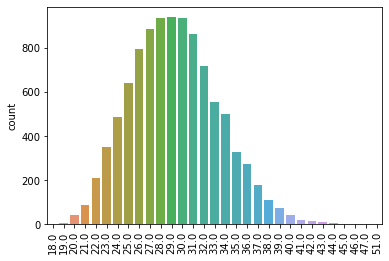

In [25]:
# Distributions of ages (once again, count each occurrance of each age without distinguishing by fighter)

total = np.concatenate((df_raw['R_age'].values,df_raw['B_age'].values))
plt.xticks(rotation=90)
sns.countplot(total)

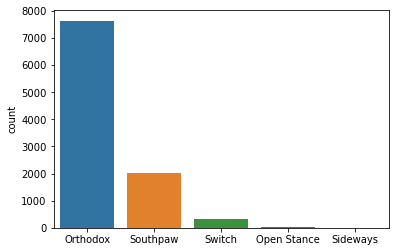

In [20]:
# Distributions of stances (counts each occurrance of a certain stance, doesn't distinguish between fighters)

total = np.concatenate((df_raw['R_Stance'].values,df_raw['B_Stance'].values))
sns.countplot(total)

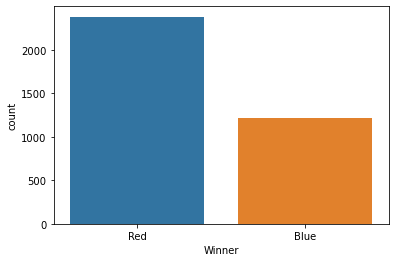

In [16]:
# Win counts between red and blue

df = pd.read_csv("UFC Data/preprocessed_data.csv")
sns.countplot(x=df['Winner'], data=df)

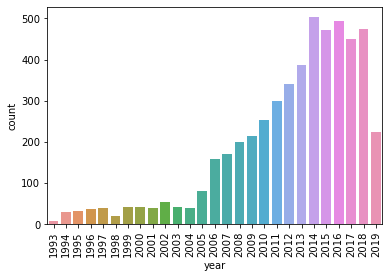

In [17]:
# Number of matches per year

df_raw = pd.read_csv("UFC Data/data.csv")
df_raw['date'] = pd.to_datetime(df_raw['date'])
df_raw['year'] = df_raw['date'].dt.year

plt.xticks(rotation=90)
sns.countplot(x=df_raw['year'], data=df_raw)

R_avg_opp_HEAD_att          R_avg_opp_SIG_STR_att        9.845529e-01
B_avg_opp_SIG_STR_att       B_avg_opp_HEAD_att           9.828780e-01
B_avg_SIG_STR_att           B_avg_HEAD_att               9.796322e-01
B_avg_LEG_landed            B_avg_LEG_att                9.792906e-01
R_avg_HEAD_att              R_avg_SIG_STR_att            9.780309e-01
                                                             ...     
B_Stance_Open Stance        R_avg_opp_CLINCH_landed      5.167264e-05
R_Stance_Southpaw           B_avg_TD_pct                 3.801896e-05
B_Height_cms                R_Stance_Switch              2.469331e-05
B_win_by_Decision_Majority  R_avg_TD_landed              1.262058e-05
B_avg_KD                    weight_class_Catch Weight    7.060715e-08
Length: 12246, dtype: float64


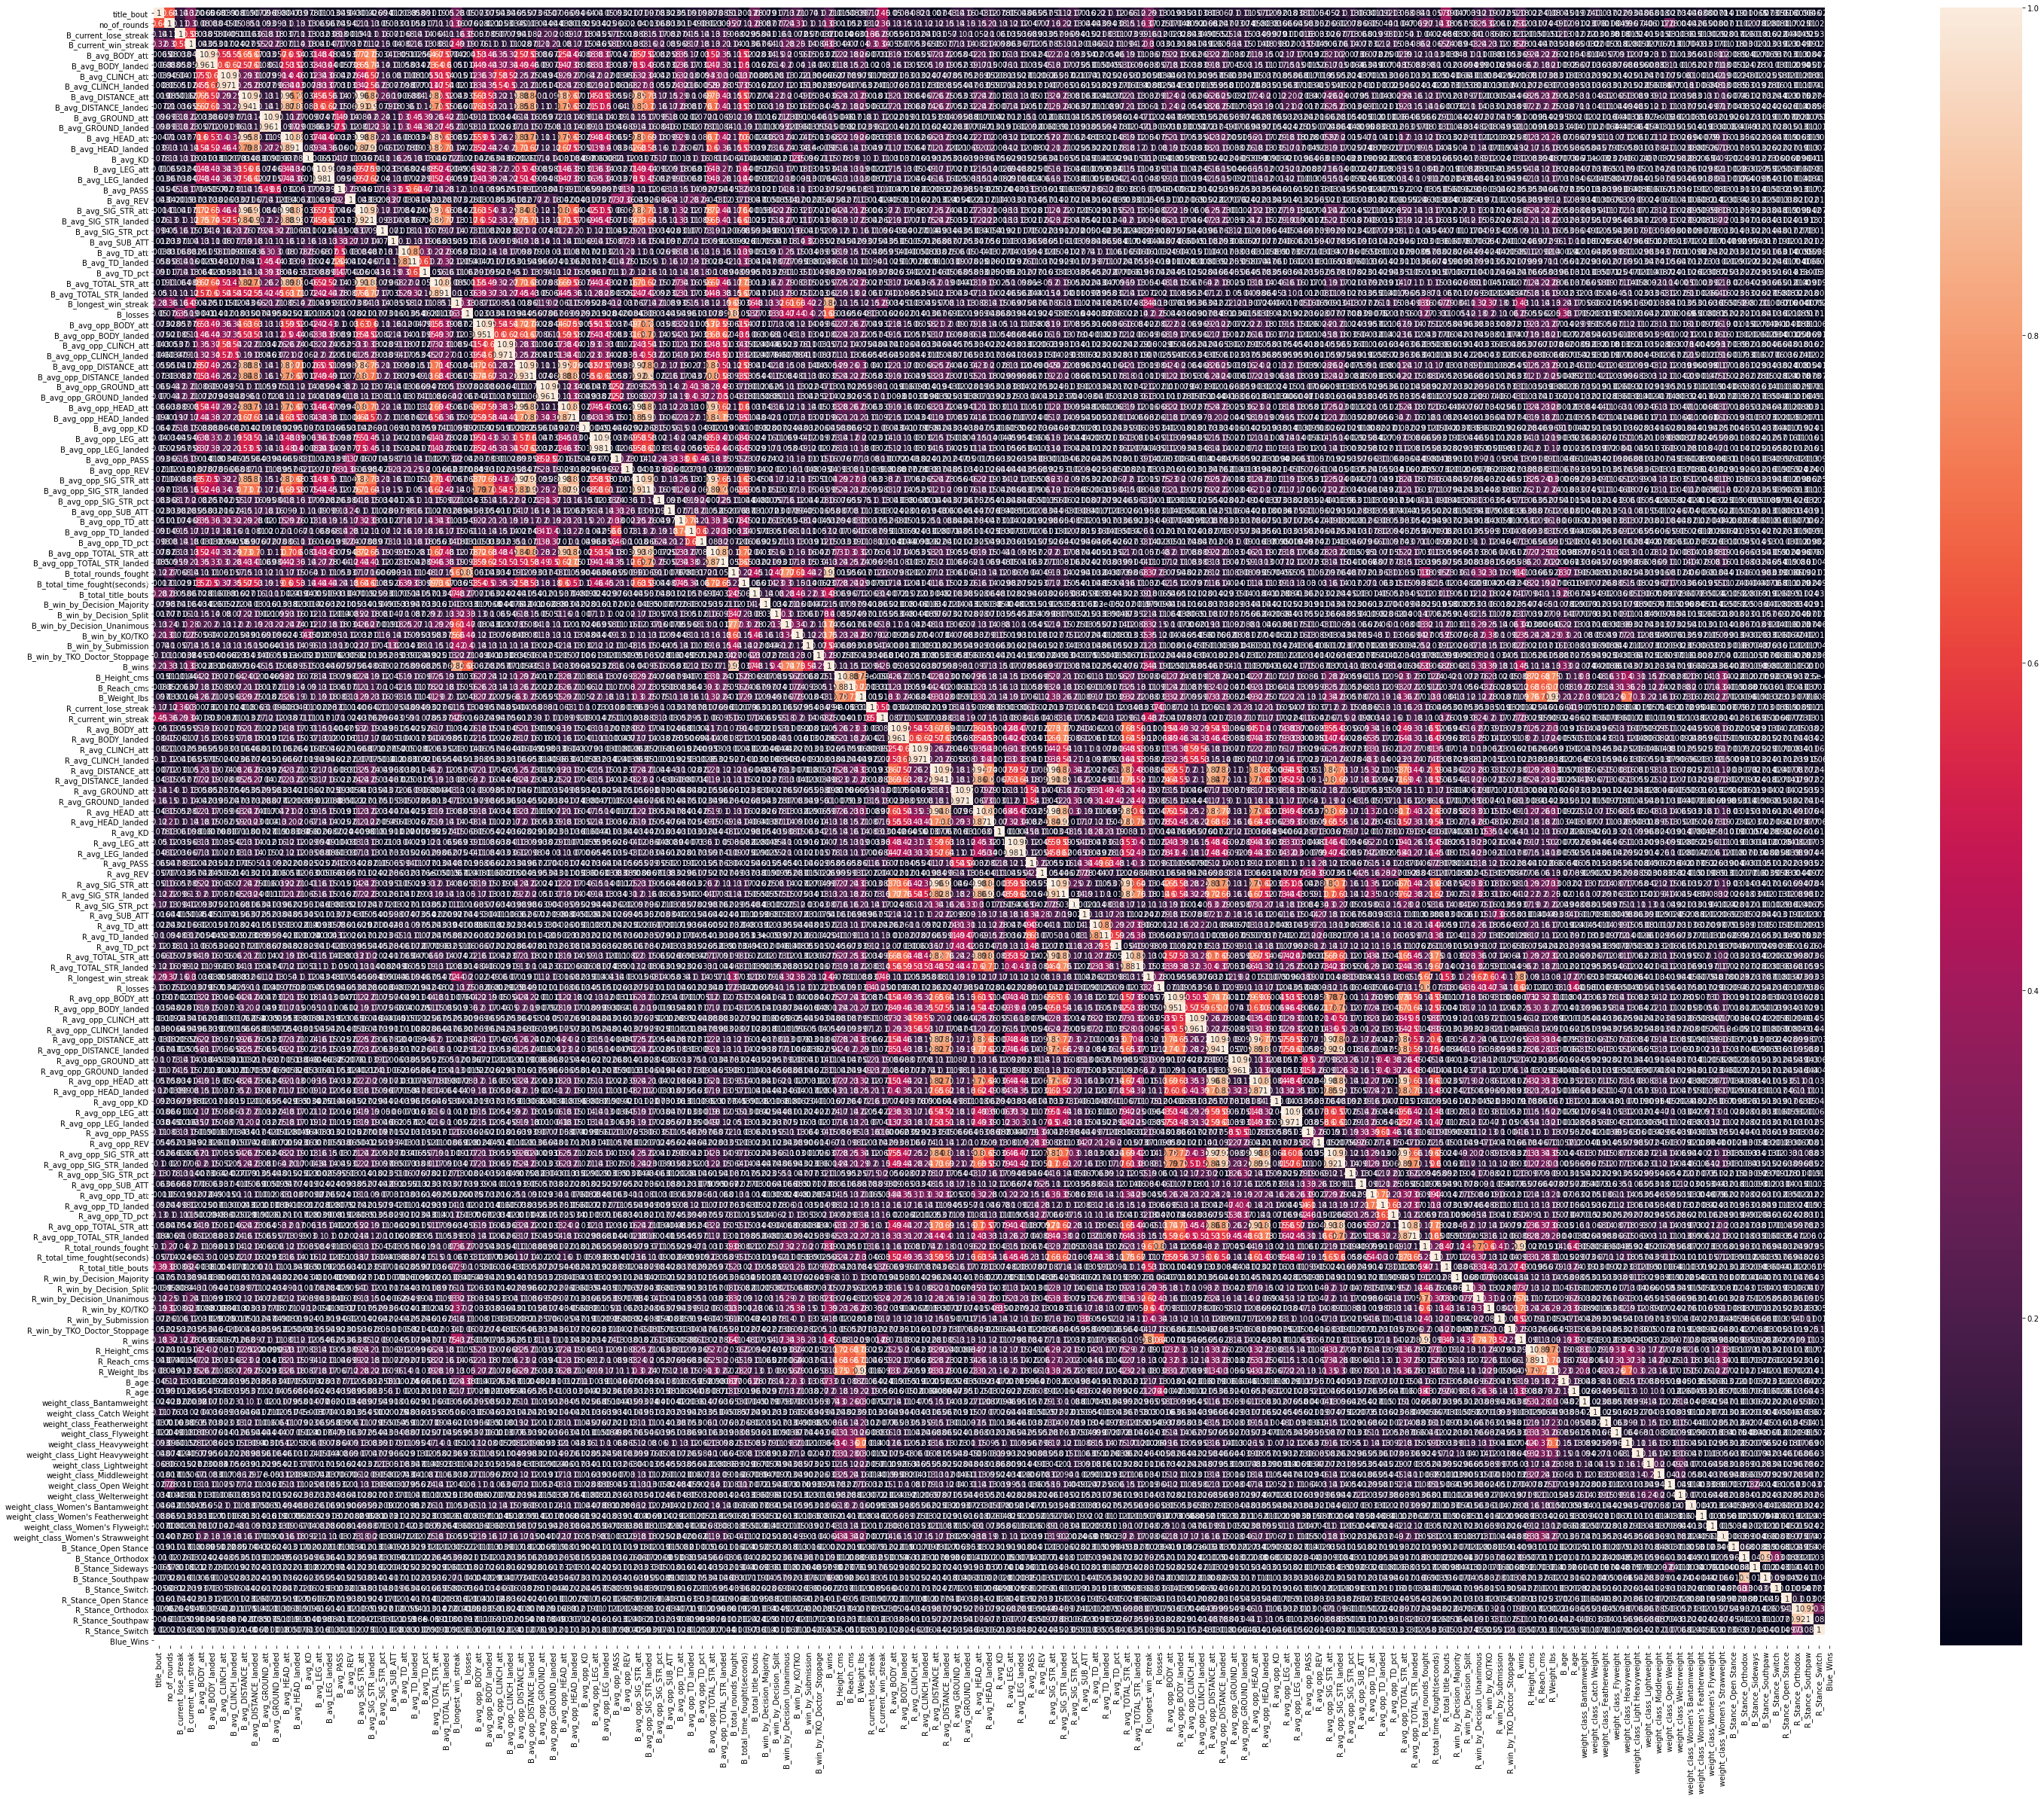

In [22]:
# Correlations

import seaborn as sns

plt.figure(figsize=(50, 40))

df = pd.read_csv("UFC Data/preprocessed_data.csv")

df['Blue_Wins'] = [1 if winner == 'Blue' else 0
                   for winner, in zip(df_pred['Blue_Wins'])]
df = df.drop(columns=['Winner', 'B_draw', 'R_draw'])

corr_matrix = df.corr(method = 'pearson').abs()

correlations = corr_matrix.stack().sort_values(ascending=False)
correlations = correlations.iloc[df.shape[1]-1::2]

print(correlations)

corr_matrix = df.corr(method = 'pearson').abs()
sns.heatmap(corr_matrix, annot=True)